In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret

data_path = 'C:/ML/datasets/data_f_60mm_good.mat'
# data_path = 'C:/ML/datasets/data_base_CP_CL_f_60mm_2_cameras_6_6.mat'

In [2]:
CL = loadmat(data_path)['CL']
CP = loadmat(data_path)['CP']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

1 100 (512, 512)
1 100 (801, 801)


10.430112387527624


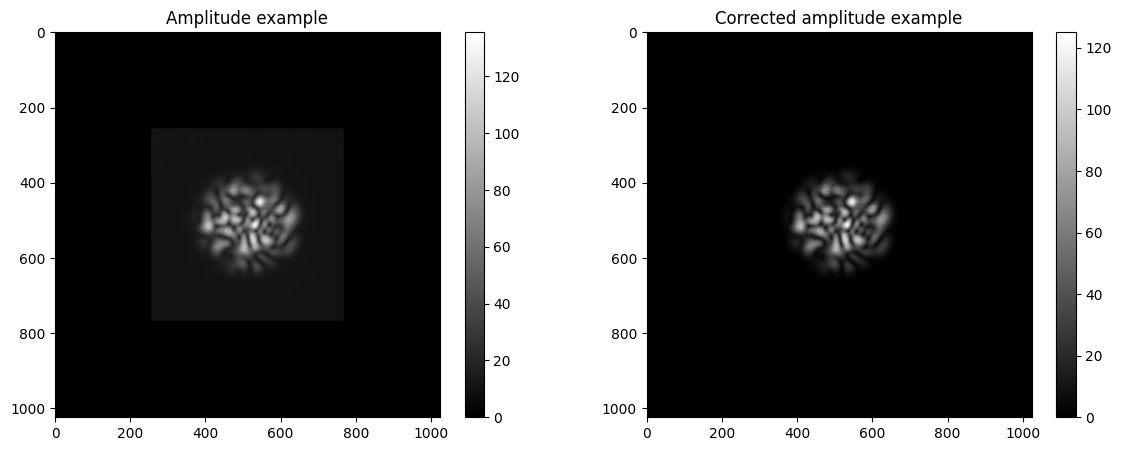

In [6]:
noise_corr = speckleret.utils.extract_noise_correction(CL, mask_trsh=0.02, plot_result=True)
print(noise_corr)

In [7]:
centroids_CP = speckleret.utils.extract_average_centroid(CP)
centroids_CL = speckleret.utils.extract_average_centroid(CL)

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (406.1723723897356, 414.1806747668517)
Average centroid CL: (252.97837852154788, 253.63111429375599)


(2513, 2513) 35.86024504803241
(2513, 2513) 104224590.0


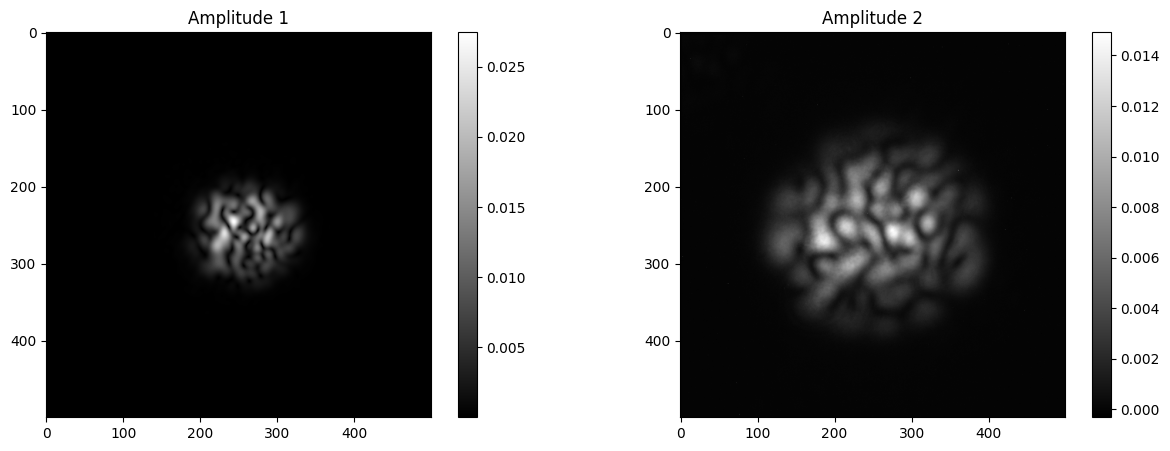

In [67]:
idx = 15
size = 256
start = 270

field = CP[0][idx]#[start:start+size, start:start+size]
CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = np.roll(field, shift=-CP_shift, axis=(0,1))
field = speckleret.transforms.pad_img(field, 2.139)

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(CL[0][idx]) - noise_corr
CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int)
ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
# ft = speckleret.utils.bin_image(ft, newshape=(256, 256))
ft = ft[:-1,:-1]

ft = speckleret.transforms.pad_img(ft, 3.92)
# ft = speckleret.transforms.pad_img(ft, 5.50)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = speckleret.plots.compare_arrays(field[1000:1500,1000:1500], ft[1000:1500,1000:1500], cmap='gray')
# _ = speckleret.plots.compare_arrays(field, ft, cmap='gray')

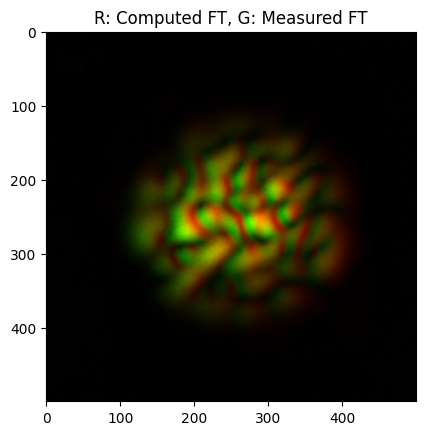

In [75]:
ft_field = speckleret.transforms.fourier_transform(field)

r = np.abs(ft_field) / np.max(np.abs(ft_field))
g = np.abs(ft) / np.max(np.abs(ft))
b = np.zeros_like(r)
img = np.dstack((r, g, b))

plt.imshow(img[1000:1500, 1000:1500])
plt.title("R: Computed FT, G: Measured FT")
plt.show()

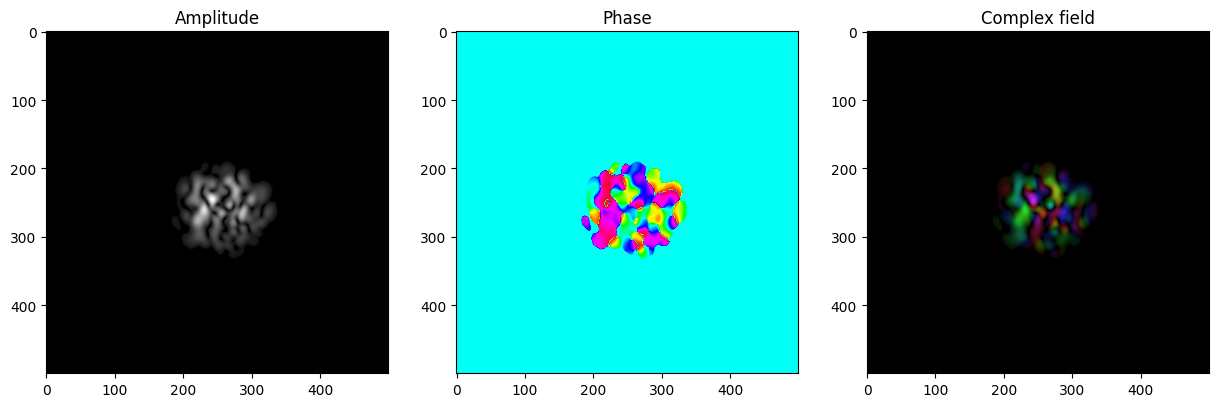

In [73]:
support = speckleret.supports.threshold_support(field, threshold=0.005)
supported_field = field.copy()
supported_field[np.logical_not(support)] = 0
_ = speckleret.plots.complex_imshow(supported_field[1000:1500, 1000:1500])

1 / 1
Quality: 0.41771084500582395
Pearson: 1.0000000000000002


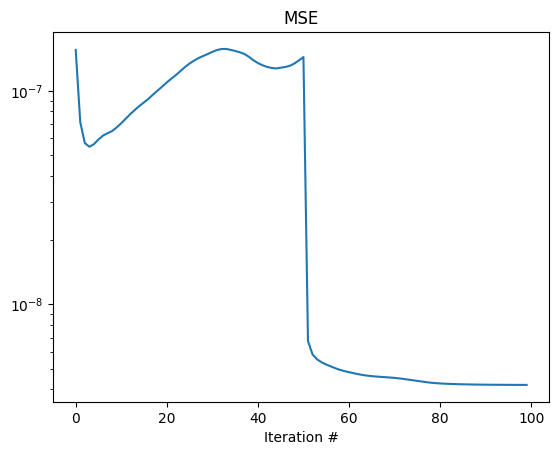

In [74]:
init = np.abs(field) * np.exp(1j * 0 * 2 * np.pi * np.random.rand(*field.shape))
y_hat, ft_hat, results = speckleret.retrieval.hio_er_fourier((np.abs(field), np.abs(ft)), support, pad=None, init=init, beta=0.9, max_iter=1, max_er_iter=50, max_hio_iter=50)

print(f"Quality: {speckleret.metrics.quality(y_hat[support], field[support])}")
print(f"Pearson: {speckleret.metrics.pearson(y_hat[support], field[support])}")

plt.figure()
plt.plot(results['mse_plane2'], label='Fourier MSE')
plt.title('MSE')
plt.xlabel('Iteration #')
plt.yscale('log')

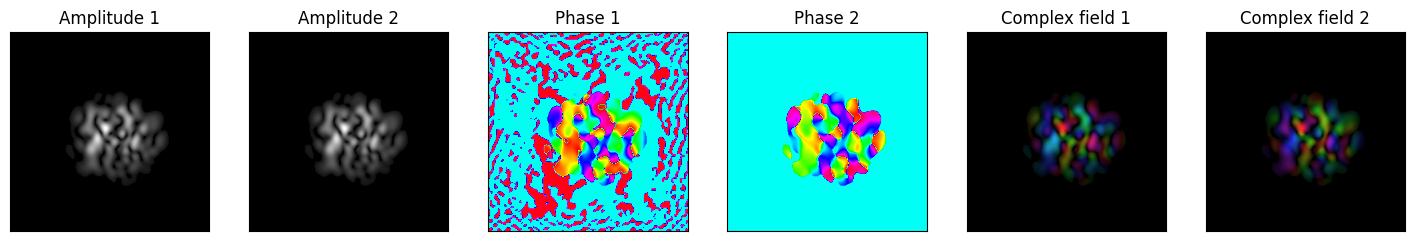

Phase error:
  - Mean: 0.72183 rad
  - Std: 2.07459 rad


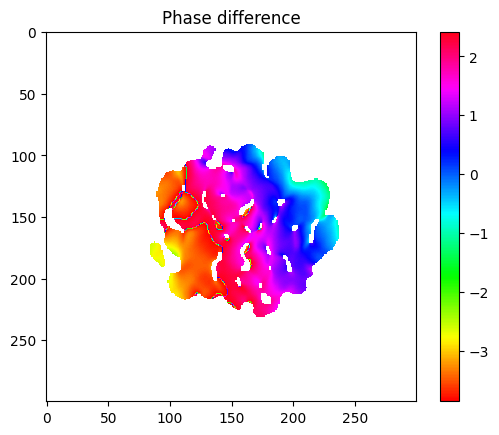

In [76]:
_ = speckleret.plots.compare_complex_fields((field * support)[1100:1400, 1100:1400], (y_hat * support)[1100:1400, 1100:1400], remove_ticks=True, figsize=(18,6))
plt.show()

speckleret.plots.phase_difference(y_hat[1100:1400, 1100:1400], field[1100:1400, 1100:1400], support[1100:1400, 1100:1400])
plt.show()